In [1]:
# !pip uninstall -y flax orbax-checkpoint jax jaxlib \
#     ml-dtypes tf-keras tensorflow tensorflow-cpu tensorflow-text \
#     tensorflow-decision-forests keras keras-hub \
#     chex optax fastai spacy tensorstore numba \
#     umap-learn pynndescent librosa shap cuml-cu12 cudf-cu12 dask-cuda

!pip install -U threadpoolctl joblib
!pip install --force-reinstall numpy==1.26.4
!pip install --upgrade scikit-learn
!pip install -U imbalanced-learn

!pip install --upgrade --force-reinstall \
    numpy==1.26.4 \
    scipy==1.13.1 \
    matplotlib==3.9.0 \
    seaborn==0.13.2 \
    pandas==2.2.2  \
    tensorflow

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-hub 0.18.1 requires tensorflow-text; platform_system != "Darwin", which is not installed.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.7 which is incompatible.
bigframes 2.1.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.16.1 which is incompatibl

In [2]:
import importlib, random, os, numpy as np, tensorflow as tf

print("===== VERSIONS =====")
for lib in ("numpy", "pandas", "sklearn", "imblearn",
            "tensorflow", "matplotlib", "seaborn"):
    m = importlib.import_module(lib if lib != "sklearn" else "sklearn")
    print(f"{lib:17s}: {m.__version__}")

print("\n===== TensorFlow devices =====")
print(tf.config.list_physical_devices())   # ← здесь будет только CPU, и это нормально

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
print(f"\nRandom seed set to {SEED}")

===== VERSIONS =====
numpy            : 1.26.4
pandas           : 2.2.2
sklearn          : 1.6.1
imblearn         : 0.13.0
tensorflow       : 2.19.0
matplotlib       : 3.9.0
seaborn          : 0.13.2

===== TensorFlow devices =====
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Random seed set to 42


In [3]:
# === @title Этап 2 (Kaggle API) — Ethereum Fraud Detection ===
# 0. (если делали раньше, шаги с pip и токеном можно пропустить)

# — 0.1 Установка библиотеки kaggle —
!pip install --quiet kaggle

# — 0.2 Загрузка kaggle.json (один раз за сессию Colab) —
#    Если токен уже лежит в ~/.kaggle, эту строку можно пропустить.
from google.colab import files, auth
import pathlib, io, os, json, pandas as pd

if not pathlib.Path("~/.kaggle/kaggle.json").expanduser().exists():
    print("📂 Загрузите kaggle.json ➜")
    token_file = files.upload()           # откроется диалог
    if "kaggle.json" not in token_file:
        raise ValueError("Нужно загрузить файл под именем kaggle.json")
    pathlib.Path("~/.kaggle").expanduser().mkdir(exist_ok=True)
    with open(pathlib.Path("~/.kaggle/kaggle.json").expanduser(), "wb") as f:
        f.write(token_file["kaggle.json"])
    !chmod 600 ~/.kaggle/kaggle.json
else:
    print("🔑 kaggle.json уже настроен")

# 1. Скачиваем архив датасета
slug = "vagifa/ethereum-frauddetection-dataset"
print(f"\n⬇️ Скачиваю датасет {slug} ...")
!kaggle datasets download -d {slug} -p ./data --force --quiet

# 2. Распаковываем
print("📦 Распаковываю ...")
!unzip -o ./data/*.zip -d ./data > /dev/null

# 3. Открываем transactions.csv
csv_path = "./data/transactions.csv"
if not os.path.exists(csv_path):
    # fallback: берем первый найденный CSV
    import glob
    found = glob.glob("./data/**/*.csv", recursive=True)
    if not found:
        raise RuntimeError("CSV-файлы не найдены в архиве.")
    csv_path = found[0]
print(f"✅ Нашёл CSV: {csv_path}")

df = pd.read_csv(csv_path)

# 4. Отладочная информация
print("\n===== SHAPE =====")
print(df.shape)            # ожидаем (9840, 49)

print("\n===== HEAD (5 строк) =====")
display(df.head())

print("\n===== Классовое соотношение (isFraud) =====")
if "FLAG" in df.columns:
    display((df["FLAG"].value_counts(normalize=True) * 100).round(2).rename("%"))
else:
    print("Столбец 'FLAG' не найден — проверьте структуру датасета.")

📂 Загрузите kaggle.json ➜


Saving kaggle.json to kaggle.json

⬇️ Скачиваю датасет vagifa/ethereum-frauddetection-dataset ...
Dataset URL: https://www.kaggle.com/datasets/vagifa/ethereum-frauddetection-dataset
License(s): DbCL-1.0
  0% 0.00/923k [00:00<?, ?B/s]
100% 923k/923k [00:00<00:00, 736MB/s]
📦 Распаковываю ...
✅ Нашёл CSV: ./data/transaction_dataset.csv

===== SHAPE =====
(9841, 51)

===== HEAD (5 строк) =====


,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS



===== Классовое соотношение (isFraud) =====


,%
FLAG,
0,77.86
1,22.14


In [4]:
df.drop(columns=["Unnamed: 0", "Index"], inplace=True, errors="ignore")
df['FLAG'].value_counts(normalize=True)

,proportion
FLAG,
0,0.778579
1,0.221421


==> Shape после удаления служебных колонок: (9841, 49)

===== ТОП-10 столбцов по числу NaN =====


,0
ERC20 most sent token type,2697
ERC20_most_rec_token_type,871
ERC20 max val rec,829
ERC20 uniq rec token name,829
ERC20 uniq sent token name,829
ERC20 avg val sent contract,829
ERC20 max val sent contract,829
ERC20 min val sent contract,829
ERC20 avg val sent,829
ERC20 max val sent,829


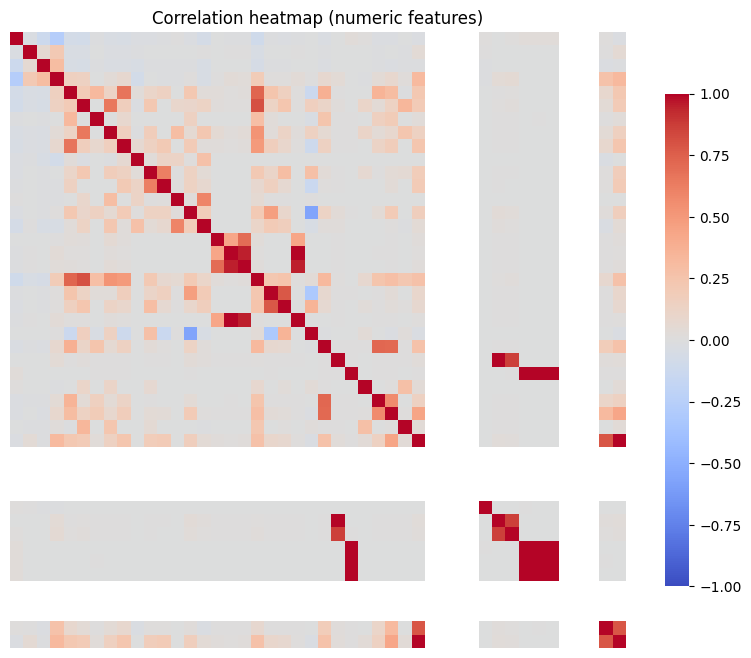


===== Признаки с нулевой дисперсией (n=7) =====
[' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx', ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx', ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract']

===== Распределение FLAG =====


,%
FLAG,
0,77.86
1,22.14


In [5]:
# === @title Этап 3: первичный анализ и инвентаризация признаков ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

# 0) Копируем исходный df (на всякий случай)
df_eda = df.copy()

# 1) Удаляем служебные колонки, если есть
svc_cols = ["Unnamed: 0", "Index"]
df_eda.drop(columns=[c for c in svc_cols if c in df_eda.columns],
            inplace=True, errors="ignore")

print("==> Shape после удаления служебных колонок:", df_eda.shape)

# 2) Проверяем пропуски
na_counts = df_eda.isna().sum()
na_nonzero = na_counts[na_counts > 0].sort_values(ascending=False)

print("\n===== ТОП-10 столбцов по числу NaN =====")
display(na_nonzero.head(10))

# 3) Корреляционная матрица Пирсона
num_cols = df_eda.select_dtypes(include=[np.number]).columns.tolist()
corr = df_eda[num_cols].corr(method="pearson")

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0,
            vmax=1, vmin=-1, square=True,
            cbar_kws={"shrink": .8}, xticklabels=False, yticklabels=False)
plt.title("Correlation heatmap (numeric features)")
plt.show()

# 4) Признаки с нулевой дисперсией (постоянные значения)
zero_var = df_eda[num_cols].loc[:, df_eda[num_cols].nunique() == 1].columns.tolist()
print(f"\n===== Признаки с нулевой дисперсией (n={len(zero_var)}) =====")
print(zero_var)

# 5) Быстрый взгляд на распределение классов (FLAG)
print("\n===== Распределение FLAG =====")
display(df_eda["FLAG"].value_counts(normalize=True).rename("%").mul(100).round(2))

In [6]:
# === @title Этап 4: очистка признаков перед обучением ===

import pandas as pd, numpy as np

# 0) Копируем исходный df
df_clean = df.copy()

# 1) Убираем пробелы в заголовках и служебные поля
df_clean.columns = df_clean.columns.str.strip()
df_clean.drop(columns=["Unnamed: 0", "Index"], inplace=True, errors="ignore")

# 2) Удаляем все строковые столбцы (Address, токены и т.п.)
str_cols = df_clean.select_dtypes(include=["object"]).columns.tolist()
print("Удаляю строковые колонки:", str_cols)
df_clean = df_clean.drop(columns=str_cols)

# 3) Удаляем признаки с нулевой дисперсией
zero_var = [
    "ERC20 avg time between sent tnx",
    "ERC20 avg time between rec tnx",
    "ERC20 avg time between rec 2 tnx",
    "ERC20 avg time between contract tnx",
    "ERC20 min val sent contract",
    "ERC20 max val sent contract",
    "ERC20 avg val sent contract",
]
to_drop = [c for c in zero_var if c in df_clean.columns]
print("Удаляю zero-variance:", to_drop)
df_clean = df_clean.drop(columns=to_drop)

# 4) Заполняем все NaN медианой по столбцу
num_cols = df_clean.columns.tolist()  # теперь все — числовые
for col in num_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# 5) Убираем одну из пары сильнокоррелирующих признаков (|ρ| > 0.9)
corr = df_clean.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
print("Удаляю сильно коррелирующие (>0.9):", high_corr_drop)
df_clean = df_clean.drop(columns=high_corr_drop)

# 6) Финальная проверка
print("\nИтоговая форма df_clean:", df_clean.shape)
print("Осталось NaN всего:", df_clean.isna().sum().sum())

Удаляю строковые колонки: ['Address', 'ERC20 most sent token type', 'ERC20_most_rec_token_type']
Удаляю zero-variance: ['ERC20 avg time between sent tnx', 'ERC20 avg time between rec tnx', 'ERC20 avg time between rec 2 tnx', 'ERC20 avg time between contract tnx', 'ERC20 min val sent contract', 'ERC20 max val sent contract', 'ERC20 avg val sent contract']
Удаляю сильно коррелирующие (>0.9): ['avg value sent to contract', 'total ether sent contracts', 'ERC20 max val rec', 'ERC20 min val sent', 'ERC20 max val sent', 'ERC20 avg val sent', 'ERC20 uniq rec token name']

Итоговая форма df_clean: (9841, 32)
Осталось NaN всего: 0


In [7]:
# === @title Этап 5: разделение и SMOTE ===
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 1) Готовим X и y
SEED = 42
X = df_clean.drop(columns=["FLAG"])
y = df_clean["FLAG"]

# 2) Разбиваем на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# 3) Распределение до SMOTE
print(">> До SMOTE (train):")
print(y_train.value_counts(), "\n")

# 4) Применяем SMOTE
smote = SMOTE(random_state=SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 5) Распределение после SMOTE
print(">> После SMOTE (train_resampled):")
print(y_train_res.value_counts())

>> До SMOTE (train):
FLAG
0    6129
1    1743
Name: count, dtype: int64 

>> После SMOTE (train_resampled):
FLAG
0    6129
1    6129
Name: count, dtype: int64


In [8]:
# === @title Этап 6 (исправленный): масштабирование признаков на всём датасете ===
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 1) Подготовка: берём все числовые признаки (кроме метки FLAG)
X_full = df_clean.drop(columns=["FLAG"]).values

# 2) Инициализируем и подгоняем scaler на всём X_full
scaler = MinMaxScaler()
scaler.fit(X_full)

# 3) Преобразуем тренировочные и тестовые данные
X_train_scaled = scaler.transform(X_train_res)  # resampled train
X_test_scaled  = scaler.transform(X_test)       # original test

# 4) Проверка диапазонов
print("== X_train_scaled ==")
print("min:", np.min(X_train_scaled), " max:", np.max(X_train_scaled))
print("shape:", X_train_scaled.shape)

print("\n== X_test_scaled ==")
print("min:", np.min(X_test_scaled), " max:", np.max(X_test_scaled))
print("shape:", X_test_scaled.shape)

== X_train_scaled ==
min: 0.0  max: 1.0
shape: (12258, 31)

== X_test_scaled ==
min: 0.0  max: 1.0
shape: (1969, 31)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [9]:
# === @title Этап 7: подготовка данных для LSTM ===
import numpy as np

# 1) Форма для LSTM: (samples, timesteps=1, features)
n_features = X_train_scaled.shape[1]

X_train_lstm = X_train_scaled.reshape(-1, 1, n_features)
X_test_lstm  = X_test_scaled.reshape(-1, 1, n_features)

# 2) Целевые массивы
y_train_lstm = y_train_res.values if hasattr(y_train_res, "values") else np.array(y_train_res)
y_test_lstm  = y_test.values       if hasattr(y_test, "values")  else np.array(y_test)

# 3) Отладочная информация
print("X_train_lstm shape:", X_train_lstm.shape)
print("X_test_lstm  shape:", X_test_lstm.shape)
print("y_train_lstm shape:", y_train_lstm.shape)
print("y_test_lstm  shape:", y_test_lstm.shape)

X_train_lstm shape: (12258, 1, 31)
X_test_lstm  shape: (1969, 1, 31)
y_train_lstm shape: (12258,)
y_test_lstm  shape: (1969,)


In [10]:
# === @title Этап 8: построение LSTM-модели ===
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1) Создаём модель
model = Sequential([
    LSTM(64, input_shape=(1, X_train_lstm.shape[2])),  # timesteps=1, features=n_features
    Dense(1, activation='sigmoid')
])

# 2) Компиляция
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 3) Вывод структуры модели
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,641 (96.25 KB)

 Trainable params: 24,641 (96.25 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# === Перед обучением: создаём папку для чекпойнтов и подключаем callback ===
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Создаём папку, если её ещё нет
os.makedirs("checkpoints", exist_ok=True)

# Шаблон имени файла: вместо {epoch:02d} подставится номер эпохи
checkpoint_path = "checkpoints/lstm_epoch{epoch:02d}.weights.h5"

# Callback для сохранения только весов модели после каждой эпохи
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,           # печатать в консоль, когда сохранено
    save_freq='epoch'    # сохранять каждый раз после завершения эпохи
)

Epoch 1/200

Epoch 1: saving model to checkpoints/lstm_epoch01.weights.h5
154/154 - 4s - 24ms/step - accuracy: 0.6185 - loss: 0.6578 - val_accuracy: 0.0000e+00 - val_loss: 0.9437
Epoch 2/200

Epoch 2: saving model to checkpoints/lstm_epoch02.weights.h5
154/154 - 1s - 5ms/step - accuracy: 0.6250 - loss: 0.6194 - val_accuracy: 0.0000e+00 - val_loss: 0.8367
Epoch 3/200

Epoch 3: saving model to checkpoints/lstm_epoch03.weights.h5
154/154 - 1s - 9ms/step - accuracy: 0.6289 - loss: 0.5876 - val_accuracy: 0.6741 - val_loss: 0.7463
Epoch 4/200

Epoch 4: saving model to checkpoints/lstm_epoch04.weights.h5
154/154 - 1s - 7ms/step - accuracy: 0.6481 - loss: 0.5701 - val_accuracy: 0.7684 - val_loss: 0.7170
Epoch 5/200

Epoch 5: saving model to checkpoints/lstm_epoch05.weights.h5
154/154 - 1s - 9ms/step - accuracy: 0.6737 - loss: 0.5623 - val_accuracy: 0.7867 - val_loss: 0.7086
Epoch 6/200

Epoch 6: saving model to checkpoints/lstm_epoch06.weights.h5
154/154 - 1s - 5ms/step - accuracy: 0.6692 - lo

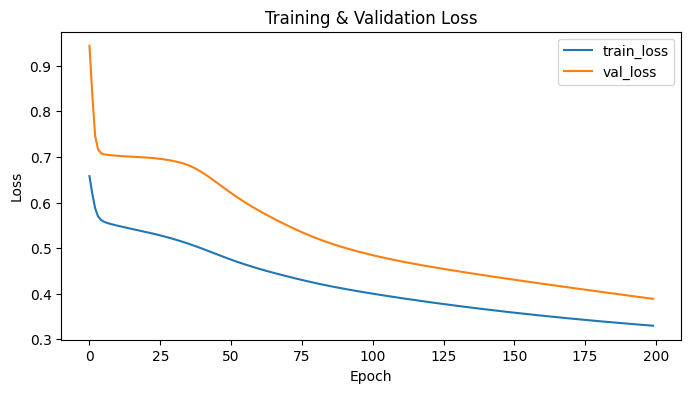

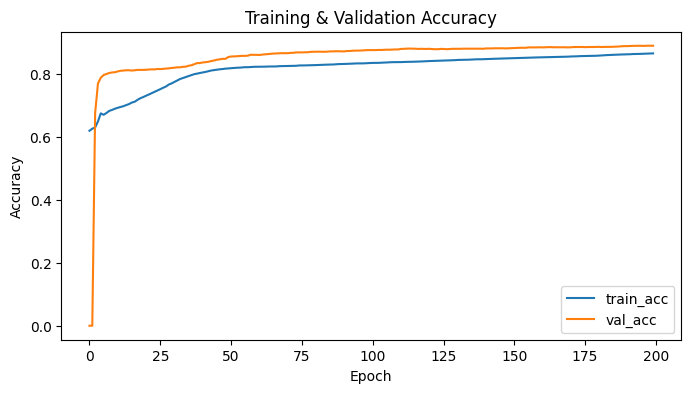

Final train_acc: 0.8640
Final val_acc:   0.8883


In [13]:
# === @title Этап 9: обучение LSTM-модели ===
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Параметры обучения
epochs = 200
batch_size = 64

# Запуск обучения
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.20,
    shuffle=True,
    callbacks=[cp_callback],
    verbose=2
)

# --- Отладочные графики ---

# 1) Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],    label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2) Accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'],    label='train_acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 3) Финальные метрики
print(f"Final train_acc: {history.history['accuracy'][-1]:.4f}")
print(f"Final val_acc:   {history.history['val_accuracy'][-1]:.4f}")

In [14]:
# === @title Этап 10: оценка модели на тесте ===
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1) Предсказания
y_pred_proba = model.predict(X_test_lstm, verbose=0)
y_pred = (y_pred_proba >= 0.5).astype(int).flatten()

# 2) Метрики
acc   = accuracy_score(y_test_lstm, y_pred)
prec  = precision_score(y_test_lstm, y_pred)
rec   = recall_score(y_test_lstm, y_pred)
f1    = f1_score(y_test_lstm, y_pred)
cm    = confusion_matrix(y_test_lstm, y_pred)

# 3) Вывод результатов
print("=== Test Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}\n")

print("=== Confusion Matrix ===")
print(cm)

=== Test Metrics ===
Accuracy : 0.8512
Precision: 0.6178
Recall   : 0.8601
F1-score : 0.7191

=== Confusion Matrix ===
[[1301  232]
 [  61  375]]


In [16]:
# === @title Этап 11: сохранение модели и препроцессинга ===
import pickle
from pathlib import Path

# Сохраняем только веса последней эпохи
model.save_weights("checkpoints/lstm_epoch200.weights.h5")

# 1) Создаём папку для артефактов
artifacts_dir = Path("artifacts")
artifacts_dir.mkdir(exist_ok=True)

# 2) Сохраняем модель
model_path = artifacts_dir / "lstm_eth_fraud_model.h5"
model.save(str(model_path))
print(f"Модель сохранена в {model_path}")

# 3) Сохраняем scaler
scaler_path = artifacts_dir / "scaler.pkl"
with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)
print(f"Scaler сохранён в {scaler_path}")

# 4) Сохраняем список признаков (чтобы при загрузке знать порядок столбцов)
feature_list = X.columns.tolist()  # X – до разбиения, без FLAG
features_path = artifacts_dir / "features_list.pkl"
with open(features_path, "wb") as f:
    pickle.dump(feature_list, f)
print(f"Список признаков сохранён в {features_path}")

# 5) Показ содержимого директории
print("\nСодержимое artifacts/:")
for p in artifacts_dir.iterdir():
    print(" -", p.name)

Модель сохранена в artifacts/lstm_eth_fraud_model.h5
Scaler сохранён в artifacts/scaler.pkl
Список признаков сохранён в artifacts/features_list.pkl

Содержимое artifacts/:
 - features_list.pkl
 - scaler.pkl
 - lstm_eth_fraud_model.h5


In [17]:
# === @title Этап 12: проверка воспроизводимости ===
import pandas as pd, numpy as np, pickle
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import load_model

# 1) Загружаем артефакты
art = Path("artifacts")
model = load_model(str(art / "lstm_eth_fraud_model.h5"))
with open(art / "scaler.pkl","rb")       as f: scaler = pickle.load(f)
with open(art / "features_list.pkl","rb") as f: features_list = pickle.load(f)

# 2) Загружаем исходный датасет
df = pd.read_csv("./data/transaction_dataset.csv")

# 3) Очистка (те же шаги, что и на Этапе 4)
df.columns = df.columns.str.strip()
df.drop(columns=["Unnamed: 0", "Index"], inplace=True, errors="ignore")
# удаляем строковые колонки
str_cols = df.select_dtypes(include=["object"]).columns
df.drop(columns=str_cols, inplace=True)
# удаляем нулевую дисперсию
zero_var = [
    "ERC20 avg time between sent tnx",
    "ERC20 avg time between rec tnx",
    "ERC20 avg time between rec 2 tnx",
    "ERC20 avg time between contract tnx",
    "ERC20 min val sent contract",
    "ERC20 max val sent contract",
    "ERC20 avg val sent contract",
]
df.drop(columns=[c for c in zero_var if c in df.columns], inplace=True)
# заполняем NaN медианой
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].median())
# удаляем сильно коррелирующие (ρ > 0.9)
corr = df.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr = [c for c in upper.columns if any(upper[c] > 0.9)]
df.drop(columns=high_corr, inplace=True)

# 4) Формируем X и y, делим
X = df[features_list]
y = df["FLAG"]
_, X_test, _, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 5) Преобразование и reshape
X_test_scaled = scaler.transform(X_test)
X_test_lstm = X_test_scaled.reshape(-1, 1, X_test_scaled.shape[1])

# 6) Инференс и метрики
y_pred = (model.predict(X_test_lstm, verbose=0) >= 0.5).astype(int).flatten()
acc   = accuracy_score(y_test, y_pred)
prec  = precision_score(y_test, y_pred)
rec   = recall_score(y_test, y_pred)
f1    = f1_score(y_test, y_pred)
cm    = confusion_matrix(y_test, y_pred)

print("=== Reproducibility Test ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}\n")
print("Confusion Matrix:")
print(cm)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


=== Reproducibility Test ===
Accuracy : 0.8512
Precision: 0.6178
Recall   : 0.8601
F1-score : 0.7191

Confusion Matrix:
[[1301  232]
 [  61  375]]
